# Importing the libraries

In [1]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import os
import skimage
import random 
import tensorflow as tf
import pandas as pd
import cv2
import sklearn
import seaborn as sns

# Part 1: Downloading colour images from BSD Dataset and preparing the dataset

## Creating a directory to save the degraded images.

In this section, we create a directory at specified location, wherein we would load all the degraded images. First of all we define a folder path from where we would extract the images. We get the list of all the image files present in the specified folder. This is followed by creating a directory called "Degraded" where the degraded images would be stored.

In [3]:
folder_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/train" #Specifying the required path
Image_list = sorted(os.listdir(folder_path)) #Sorting the list so that the names of image files match the order of names of undegraded image files

print("Number of images in train folder : ",len(Image_list))

new_folder_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Degraded" #Specifying the path to store degraded images

#try except block to make sure that directory isn't created if it already exists
try:
  os.mkdir(new_folder_path)
  print("Directory to store degraded image created")
except:
  print("A directory already exists to store degraded image")

Number of images in train folder :  200
A directory already exists to store degraded image


## Dataset generation

a.  Largest Odd window size = 13

b. Blur kernels and noise kernels used : 


*   Blur from cv2 which would randomly select a blur value between 5 and 13 and apply the filter.
 

*   Noise kernel which has a random variance is applied to each image.

c. Each image is loaded from the folder of images (100 were loaded), blur and noise kernels were applied on each image, at the same time, central pixel from original image and 13x13 patch from degraded image was extracted to create a pandas dataframe 'dataset'.

In [ ]:
W = 13 #Setting the Window size for patch extraction of degraded image
dataset = pd.DataFrame() #DataFrame to store the dataset


for path in Image_list[0:100]: #We take only 100 images to generate the dataset. Iterating through the 50 images one by one

  path_name = folder_path + "/" + path 
  image = skimage.io.imread(path_name) #Reading the image 

  x,y = image.shape[0],image.shape[1] #Reading the shape of image

  undegraded_image = np.reshape(image,(1,x,y,3)) #Image reshaped for suitable tensor operations

  undegraded_patch = tf.image.extract_patches(undegraded_image,sizes=[1,W,W,1],strides=[1,W,W,1], rates = [1,1,1,1],padding='VALID') #extracting patches from original image
  undegraded_patch = tf.reshape(undegraded_patch,[-1,W,W,3]) 
  central_pixels = undegraded_patch[:,int((W-1)/2),int((W-1)/2),:] #Finding the central pixels of the patches of clean image
  central_pixels = tf.reshape(central_pixels,[-1,1,1,3])

  Kernel = random.randrange(5,13+1,2) #Generating a random odd number between 5 and 13. The number will be the size of the blur kernel
  blurred_image = cv2.blur(image,(Kernel,Kernel)) #Blurring the image
  variance = 0.1*random.random() #Returns random value for variance of Gaussian noise. This also follows gaussian distribution.

  noisy_image = skimage.util.random_noise(blurred_image,mode='gaussian',var=variance) #Addition of Gaussian noise
  noisy_image = skimage.util.img_as_ubyte(noisy_image)
  degraded_image = np.reshape(noisy_image,(1,x,y,3))

  degraded_patch = tf.image.extract_patches(degraded_image,sizes=[1,W,W,1],strides=[1,W,W,1],rates = [1,1,1,1],padding = 'VALID') #Extracting patches of degraded image
  degraded_patch = tf.reshape(degraded_patch,[-1,W,W,3])

  X = tf.reshape(degraded_patch,[-1,W*W*3]).numpy() #converting patches into a 2D tensor, these work as input features.
  Y = tf.reshape(central_pixels,[-1,3]).numpy() #Converting the clean central pixels into 2D tensor, these work as outputs (R,G,B)

  temp_data = tf.concat([X,Y],axis=1) #Joining both the tensors column wise and converting into numpy array
  temp_data = temp_data.numpy()
  temp_dataframe = pd.DataFrame(temp_data) #creation of temporary dataframe

  frame = [dataset,temp_dataframe]
  dataset = pd.concat(frame) # Concatinate the final dataset with the data extracted in this iteration

  os.chdir(new_folder_path)
  noisy_image = skimage.img_as_ubyte(noisy_image) 
  skimage.io.imsave(path,noisy_image) #Storing the degraded image in "Degraded" folder


A small peak on the degraded Image and it's comparison with clean Image

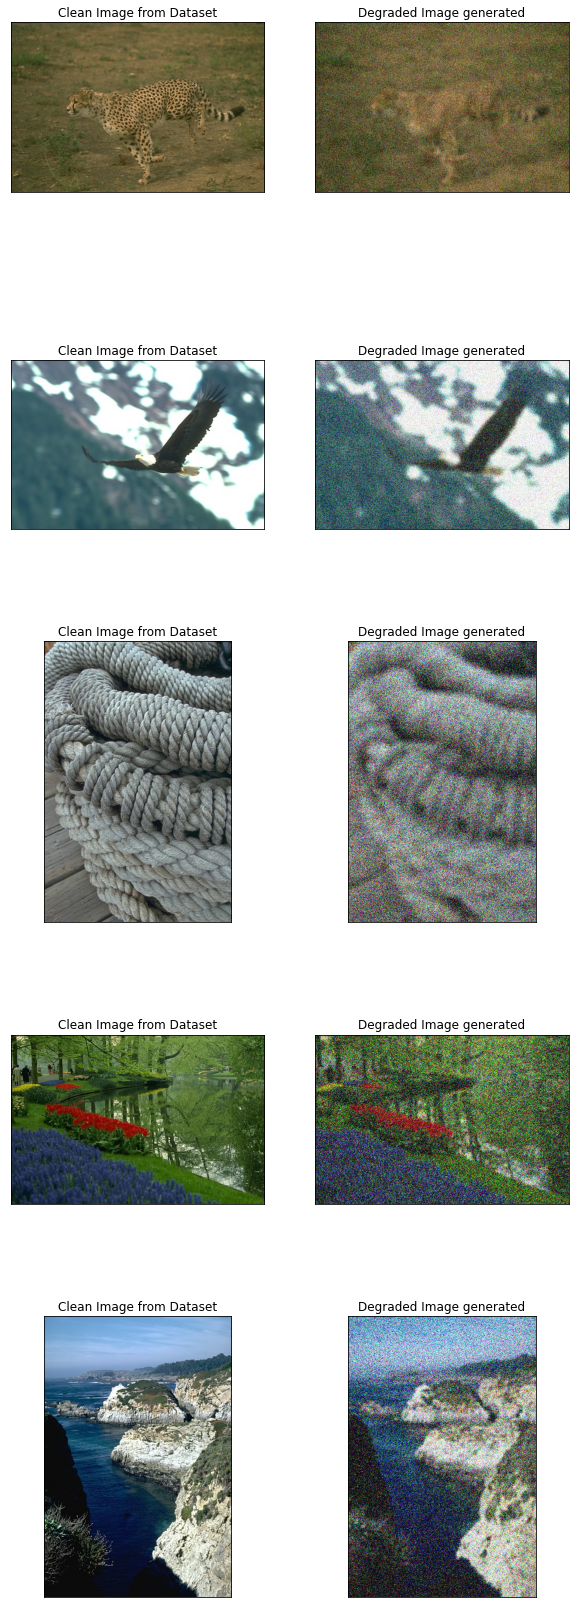

In [5]:

figure = plt.figure(figsize = [10,30])

for i in range(11,21,2):
  
  Clean = skimage.io.imread(folder_path + "/" + Image_list[i+14])
  Degraded = skimage.io.imread(new_folder_path + "/"+ Image_list[i+14])

  figure.add_subplot(5,2,i-10)
  plt.imshow(Clean)
  plt.title("Clean Image from Dataset")
  plt.xticks([])
  plt.yticks([])

  figure.add_subplot(5,2,i-10+1)
  plt.imshow(Degraded)
  plt.title("Degraded Image generated")
  plt.xticks([])
  plt.yticks([])

Lets look at the dataset we just generated, as we can see, there are a total of 88800 training samples and there are 510 columns. The last three columns correspond to the clean central pixel for a given patch of degraded image.

In [ ]:
dataset.head()

0    1    2    3    4    5    6    ...  503  504  505  506  507  508  509
0  153  146  130  128  151  114  106  ...  188  166  155  113  135  147  137
1  114  135  129  162  133   90   96  ...  101  115  121  186  140  153  143
2   74  106  109  138  118   95  122  ...  148  146  168  145  120  136  125
3  115  133   85  126  145  136  148  ...  170  160  172  173  115  131  120
4   94  158  167  139  118  106  171  ...  181  144  150  155  134  143  138

[5 rows x 510 columns]

More information about the dataset.

In [ ]:
dataset.describe()

0             1    ...           508           509
count  88800.000000  88800.000000  ...  88800.000000  88800.000000
mean     111.692624    114.603964  ...    112.979223     94.668018
std       71.793578     70.343501  ...     59.340704     59.975007
min        0.000000      0.000000  ...      0.000000      0.000000
25%       56.000000     62.000000  ...     68.000000     48.000000
50%      107.000000    111.000000  ...    107.000000     87.000000
75%      162.000000    164.000000  ...    150.000000    133.000000
max      255.000000    255.000000  ...    255.000000    255.000000

[8 rows x 510 columns]

Saving the dataset as csv file.

In [ ]:
dataset_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Dataset.csv"

dataset.to_csv(dataset_path,index = False)

Testing whether we are generating correct data or not. We randomly selected a sample, took the last 3 columns as output, took all the columns except the last 3 as input, reshape them and display them.

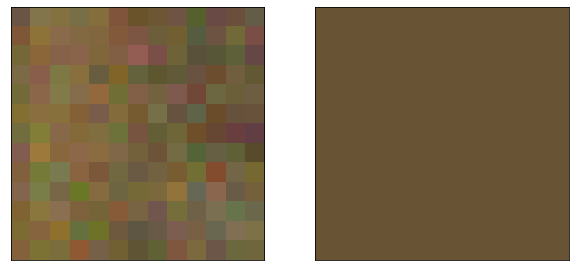

In [ ]:
w = 13

y_train = dataset.iloc[:,-3:] #Locate final 3 columns as y_train

x_train = dataset.iloc[:,0:-3] #Locate first all columns as x_train

patch = x_train.iloc[62476].to_numpy() #62476 is just a random number to see the patch at location 62476, and also the corresponding central cleaned pixel.
patch = np.reshape(patch,(w,w,3))
pixel = y_train.iloc[62476].to_numpy()
pixel = np.reshape(pixel,(1,1,3))

figure = plt.figure(figsize=[10,7])
figure.add_subplot(1,2,1)
plt.imshow(patch)
plt.xticks([])
plt.yticks([])

figure.add_subplot(1,2,2)
plt.imshow(pixel)
plt.xticks([])
plt.yticks([])

plt.show()

# Model 1 : Using Neural Network

Selecting the window size of W = 13.

First, we split the data into train, validation and test.

In [ ]:
from fast_ml.model_development import train_valid_test_split

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(dataset, target = [507,508,509], 
                                                                            train_size=0.7, valid_size=0.15, test_size=0.15)


In [ ]:
print('''
The size of train data : {}
The size of validation data : {}
The size of test data : {}
'''.format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))


The size of train data : 62159
The size of validation data : 13320
The size of test data : 13321



Now we create DataFrames to store the corresponding datasets and store the datasets as CSV files

In [ ]:
train_df = pd.DataFrame() #To store training dataset
validation_df = pd.DataFrame() #To store validation dataset
test_df = pd.DataFrame() #To store test dataset

train_df = pd.concat([X_train,Y_train],axis = 1)
validation_df = pd.concat([X_valid,Y_valid],axis=1)
test_df = pd.concat([X_test,Y_test],axis=1)

dataset_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Dataset_Train.csv"

train_df.to_csv(dataset_path,index = False)

dataset_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Dataset_Valid.csv"

validation_df.to_csv(dataset_path,index = False)

dataset_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Dataset_Test.csv"

test_df.to_csv(dataset_path,index = False)

Load the Saved Datasets. The Datasets are loaded in training (X_train, Y_train), validation (X_valid, Y_valid) and test (X_test,Y_test)

In [5]:
path_split_data = r"/content/drive/MyDrive/213070002_EE610_Assignment_2"

train = pd.read_csv(path_split_data + "/Dataset_Train.csv",index_col = False)
test = pd.read_csv(path_split_data + "/Dataset_Test.csv",index_col = False)
validation = pd.read_csv(path_split_data + "/Dataset_Valid.csv",index_col = False)

X_train = train.iloc[:,0:-3] #Splitting the train dataset into Input
Y_train = train.iloc[:,-3:] #Splitting the train dataset into Output

X_test = test.iloc[:,0:-3] #Splitting the test dataset into Input
Y_test = test.iloc[:,-3:] #Splitting the test dataset into Output

X_valid = validation.iloc[:,0:-3] #Splitting the validation dataset into Input
Y_valid = validation.iloc[:,-3:] #Splitting the validation dataset into Output

Printing few Patches from the training dataset to check whether we are getting the correct central pixel or not.

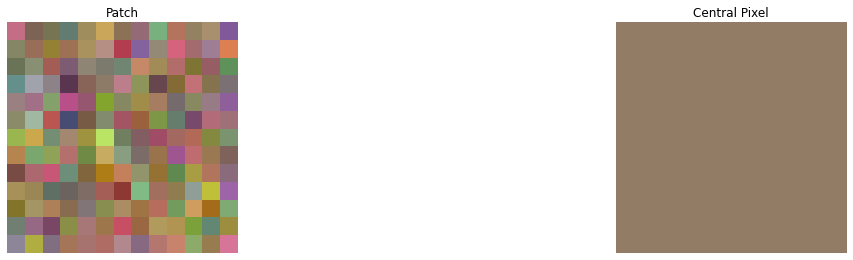

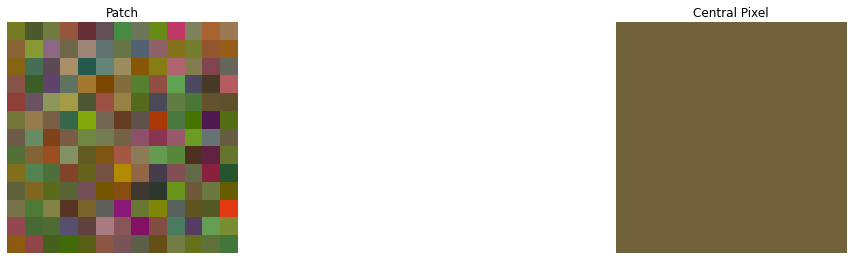

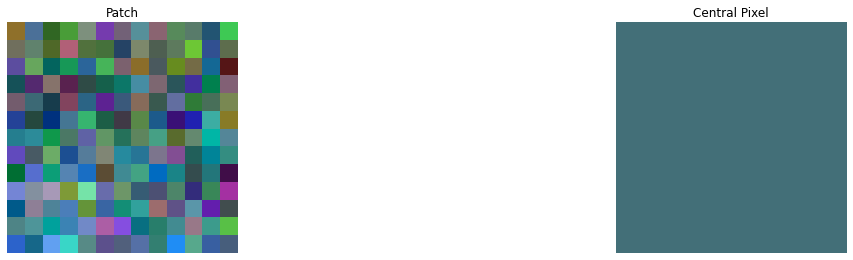

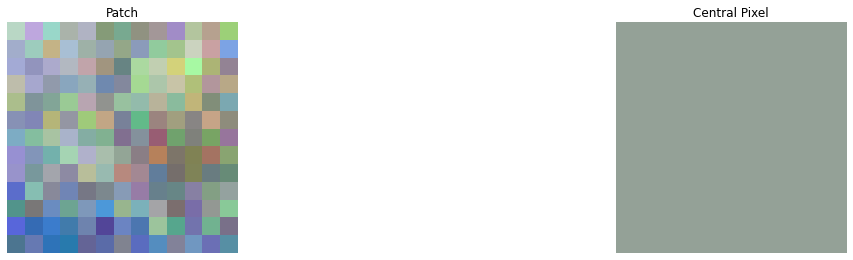

In [6]:
N = 1902 #Any random number to check patches.

for i in range(N+1,N+5):

  X = X_train.iloc[i,:].to_numpy()
  Y = Y_train.iloc[i,:].to_numpy()

  X = np.reshape(X,(13,13,3))
  Y = np.reshape(Y,(1,1,3))

  figure = plt.figure(figsize=[20,50])

  figure.add_subplot(10,2,2*(i-N)-1)
  plt.imshow(X)
  plt.axis("off")
  plt.title("Patch")

  figure.add_subplot(10,2,2*(i-N))
  plt.imshow(Y)
  plt.axis("off")
  plt.title("Central Pixel")

Model training begins here.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

Creating a Neural Network with 3 hidden layers. 64 neurons in each layer. Final layer has 3 neurons to predict R,G,B of the central pixel.

In [ ]:
number_epochs = 16

model = keras.Sequential()
model.add(layers.Dense(64,input_dim = X_train.shape[1],activation = "gelu")) #gelu is the activation giving better results here.
model.add(layers.Dense(64,activation = "gelu"))
model.add(layers.Dense(64,activation = "gelu"))
model.add(layers.Dense(3,activation = "gelu"))
model.compile(loss = "MSE",optimizer = "adam")

#Callback to pull out the weights for which validation_loss is minimum.
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience = number_epochs,mode="min",restore_best_weights=True) 

history = model.fit(X_train,Y_train,epochs = number_epochs,batch_size = 128,validation_data = (X_valid,Y_valid),callbacks = [callback])

Epoch 1/16
486/486 [==============================] - 3s 5ms/step - loss: 728.4825 - val_loss: 497.9146
Epoch 2/16
486/486 [==============================] - 2s 4ms/step - loss: 483.4943 - val_loss: 472.1557
Epoch 3/16
486/486 [==============================] - 2s 4ms/step - loss: 462.9801 - val_loss: 505.2822
Epoch 4/16
486/486 [==============================] - 2s 4ms/step - loss: 456.2157 - val_loss: 478.5585
Epoch 5/16
486/486 [==============================] - 2s 4ms/step - loss: 451.1521 - val_loss: 454.1732
Epoch 6/16
486/486 [==============================] - 2s 4ms/step - loss: 445.0616 - val_loss: 443.8545
Epoch 7/16
486/486 [==============================] - 2s 4ms/step - loss: 444.0827 - val_loss: 461.0584
Epoch 8/16
486/486 [==============================] - 2s 4ms/step - loss: 446.4138 - val_loss: 457.8918
Epoch 9/16
486/486 [==============================] - 2s 4ms/step - loss: 443.3467 - val_loss: 453.9571
Epoch 10/16
486/486 [==============================] - 2s 4ms/st

In [6]:
model.evaluate(X_test,Y_test) #Evaluating the result on test set

417/417 [==============================] - 1s 2ms/step - loss: 434.9421


434.9421081542969

Plotting the logarithm of the loss so that loss can be visualized properly. Blue line represents training loss, orange line represents validation loss.

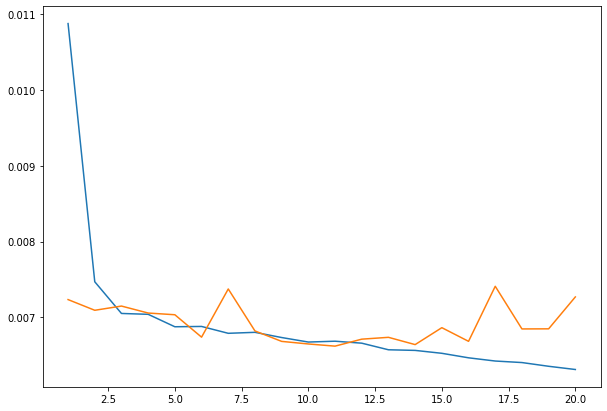

In [ ]:
epochs = np.arange(1,number_epochs+1,1)

loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig_loss = plt.figure(figsize = [10,7])
sns.lineplot(x = epochs,y=(np.array(loss)))
sns.lineplot(x = epochs,y=(np.array(val_loss)))
plt.show()

Plot description:

On X axis, number of epochs
On Y axis, Loss in Log scale

orange = Validation loss
blue = train loss

As we can see, the validation has started to rise once again after 15th, 16th epoch. So we use early stopping to extract the weight corresponding to minimum validation loss in 20 epochs.

Saving the model everytime so that we don't need to train the model again and again.

In [ ]:
model_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Model.h5"
model.save(model_path)

Loading the model from the drive.

In [3]:
model = keras.models.load_model(r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Model.h5")

Here, we extract fit the model on our prediction set and see whether the output pixel predicted matches the original central pixel or not.

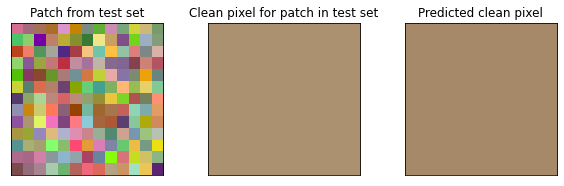

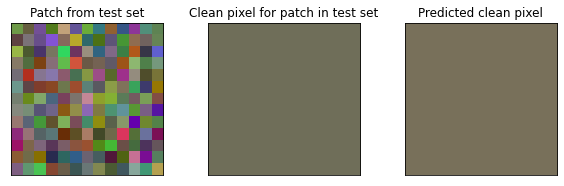

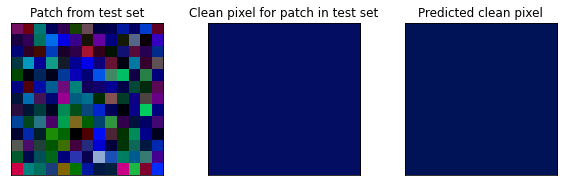

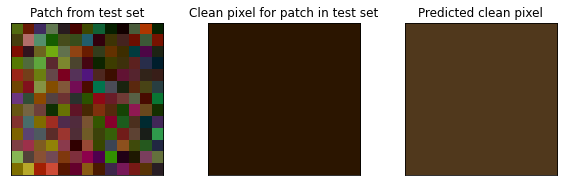

In [14]:
Y_predict = model.predict(X_test)
Y_predict = np.reshape(Y_predict,(-1,3)) #Reshaping the pixel
Y_predict = (Y_predict).astype(int)

N = 11324 #Random value for getting few samples from test set

for i in range(N+1,N+5):

  X = X_test.iloc[i,:].to_numpy()
  Y = Y_test.iloc[i,:].to_numpy()
  Y2 = Y_predict[i,:]

  X = np.reshape(X,(13,13,3))
  Y = np.reshape(Y,(1,1,3))
  Y2 = np.reshape(Y2,(1,1,3))

  figure = plt.figure(figsize=[10,50])

  figure.add_subplot(15,3,3*(i-N)-2)
  plt.imshow(X)
  plt.title("Patch from test set")
  plt.xticks([])
  plt.yticks([])

  figure.add_subplot(15,3,3*(i-N) - 1)
  plt.imshow(Y)
  plt.title("Clean pixel for patch in test set")
  plt.xticks([])
  plt.yticks([])

  figure.add_subplot(15,3,3*(i-N))
  plt.imshow(Y2)
  plt.title("Predicted clean pixel")
  plt.xticks([])
  plt.yticks([])

Loading few test images from degraded images. The folder used consists of images which were degraded using other blur models and kernels. (Different blur and noise models)

link for Grapes image : https://www.researchgate.net/figure/Gaussian-noise-Nm0-s-2-01-applied-to-the-test-image-of-Figure-1-Colour-values_fig6_4245785

link for Rose image : http://www.aforgenet.com/framework/docs/html/148dcb1f-00e7-518e-676d-14ba49979abc.htm

In [7]:
path_test_img = r"/content/drive/MyDrive/EE_610_test/Degraded/"

test_image_1 = skimage.io.imread(path_test_img + "124084.jpg")
test_image_2 = skimage.io.imread(path_test_img + "35010.jpg")
test_image_3 = skimage.io.imread("/content/grapes.jpg")
test_image_4 = skimage.io.imread("/content/Rose.jpg")

def predict_image(image):
  
  x,y = image.shape[0],image.shape[1] #Reading the shape of image
  image = np.reshape(image,(1,x,y,3))
  degraded_patch = tf.image.extract_patches(image,sizes=[1,13,13,1],strides=[1,1,1,1],rates = [1,1,1,1],padding = 'SAME') #Extracting patches of degraded image
  degraded_patch = tf.reshape(degraded_patch,[-1,13,13,3]) #Reshaping the patches to [N,13,13,3] where N is total patches of Image.

  X = tf.reshape(degraded_patch,[-1,13*13*3]).numpy() #converting patches into a 2D tensor, these work as input features.
  Y = model.predict(X)
  Y = (Y).astype(int)
  Y = np.where(Y > 255,255,Y) #Taking care of negative pixels
  Y = np.reshape(Y,(x,y,3))
  return Y
  

Y1 = (predict_image(test_image_1))
Y2 = (predict_image(test_image_2))
Y3 = (predict_image(test_image_3))
Y4 = (predict_image(test_image_4))


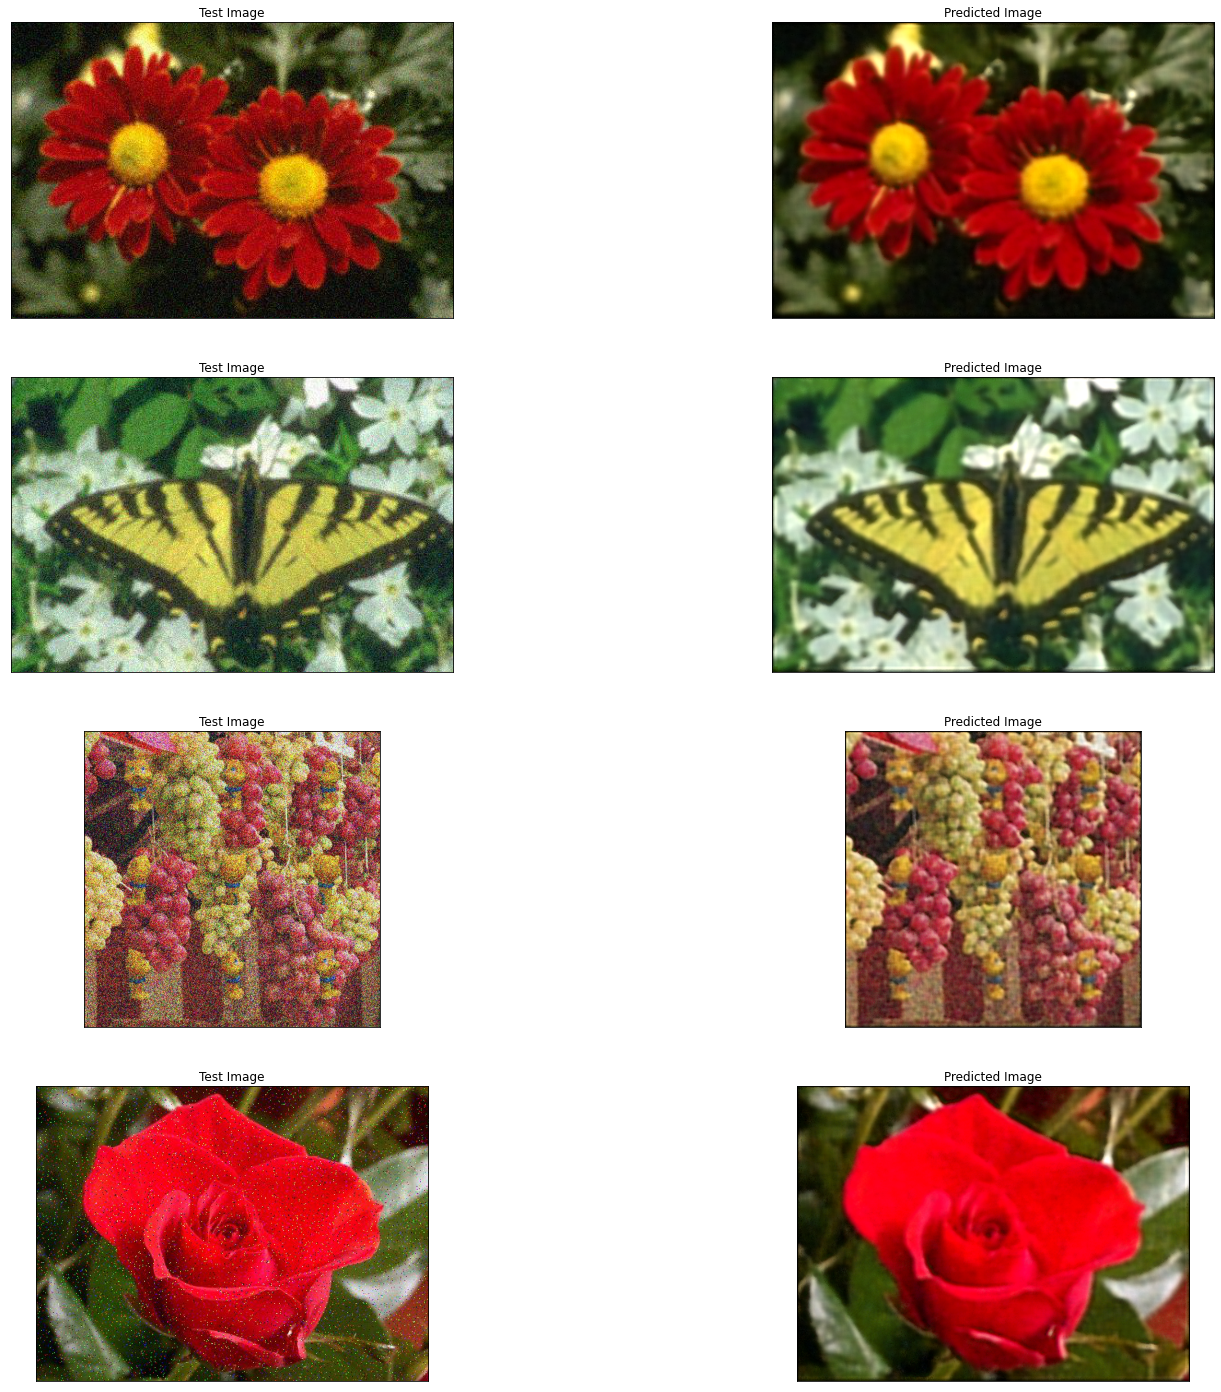

In [8]:
figure1 = plt.figure(figsize = [25,25])

for i in range(0,4):

  figure1.add_subplot(4,2,2*(i) + 1)
  test = "test_image_" + str(i+1)
  plt.imshow(eval(test))
  plt.title("Test Image")
  plt.xticks([])
  plt.yticks([])

  figure1.add_subplot(4,2,2*(i+1))
  Y = "Y"+str(i+1)
  plt.imshow(eval(Y))
  plt.title("Predicted Image")
  plt.xticks([])
  plt.yticks([])

plt.show()

For window of size 7,9,11. We use the same neural network architecture. First we define a function to extract wxw patches from 13x13 original patches.

In [12]:
def extract_small_w(X,w): #Function to return wxw patches from X which contains 13x13 patches

  X_w = X.to_numpy()

  X_w = np.reshape(X_w,(-1,13,13,3))

  LL = (13-1)//2 - (w-1)//2
  UL = (13-1)//2 + (w-1)//2 + 1

  X_w = X_w[:,LL:UL,LL:UL,:]

  X_w = np.reshape(X_w,(-1,w*w*3))
  return X_w


In [13]:
model_7 = keras.Sequential()
model_9 = keras.Sequential()
model_11 = keras.Sequential()

In [14]:
X_7 = extract_small_w(X_train,7)
X_7_valid = extract_small_w(X_valid,7)
X_7_test = extract_small_w(X_test,7)

X_9 = extract_small_w(X_train,9)
X_9_valid = extract_small_w(X_valid,9)
X_9_test = extract_small_w(X_test,9)

X_11 = extract_small_w(X_train,11)
X_11_valid = extract_small_w(X_valid,11)
X_11_test = extract_small_w(X_test,11)


In [15]:
model_7.add(layers.Dense(64,input_dim = X_7.shape[1],activation = "gelu")) #gelu is the activation giving better results here.
model_7.add(layers.Dense(64,activation = "gelu"))
model_7.add(layers.Dense(64,activation = "gelu"))
model_7.add(layers.Dense(3,activation = "gelu"))
model_7.compile(loss = "MSE",optimizer = "adam")

#Callback to pull out the weights for which validation_loss is minimum.
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience = 50,mode="min",restore_best_weights=True) 


In [16]:
model_9.add(layers.Dense(64,input_dim = X_9.shape[1],activation = "gelu")) #gelu is the activation giving better results here.
model_9.add(layers.Dense(64,activation = "gelu"))
model_9.add(layers.Dense(64,activation = "gelu"))
model_9.add(layers.Dense(3,activation = "gelu"))
model_9.compile(loss = "MSE",optimizer = "adam")

#Callback to pull out the weights for which validation_loss is minimum.
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience = 50,mode="min",restore_best_weights=True) 


In [17]:
model_11.add(layers.Dense(64,input_dim = X_11.shape[1],activation = "gelu")) #gelu is the activation giving better results here.
model_11.add(layers.Dense(64,activation = "gelu"))
model_11.add(layers.Dense(64,activation = "gelu"))
model_11.add(layers.Dense(3,activation = "gelu"))
model_11.compile(loss = "MSE",optimizer = "adam")

#Callback to pull out the weights for which validation_loss is minimum.
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience = 50,mode="min",restore_best_weights=True) 


In [18]:
history_7 = model_7.fit(X_7,Y_train,epochs = 50, validation_data = (X_7_valid,Y_valid),batch_size=64,verbose=0,callbacks = [callback])

In [19]:
history_9 = model_9.fit(X_9,Y_train,epochs = 50, validation_data = (X_9_valid,Y_valid),batch_size=64,verbose=0,callbacks = [callback])

In [20]:
history_11 = model_11.fit(X_11,Y_train,epochs = 50, validation_data = (X_11_valid,Y_valid),batch_size=64,verbose=0,callbacks = [callback])

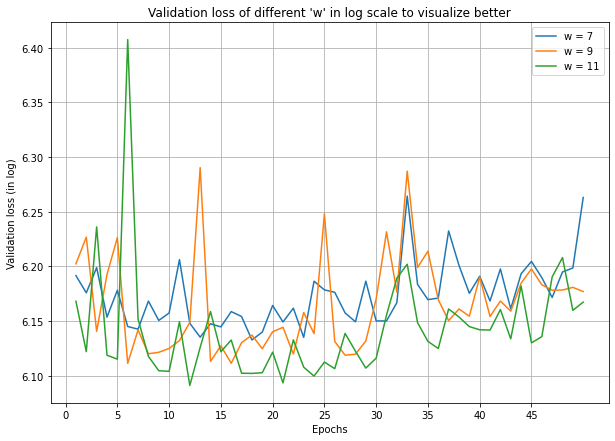

In [21]:
epochs = np.arange(1,50+1,1)

loss7 = history_7.history["loss"]
val_loss7 = history_7.history["val_loss"]

loss9 = history_9.history["loss"]
val_loss9 = history_9.history["val_loss"]

loss11 = history_11.history["loss"]
val_loss11 = history_11.history["val_loss"]

fig_loss = plt.figure(figsize = [10,7])
sns.lineplot(x = epochs,y=np.log(np.array(val_loss7)))
sns.lineplot(x = epochs,y=np.log(np.array(val_loss9)))
sns.lineplot(x = epochs,y=np.log(np.array(val_loss11)))
plt.title("Validation loss of different 'w' in log scale to visualize better")
plt.legend(["w = 7","w = 9","w = 11"])
plt.xlabel("Epochs")
plt.ylabel("Validation loss (in log)")
plt.grid()
plt.xticks(np.arange(0,50,5))
plt.show()

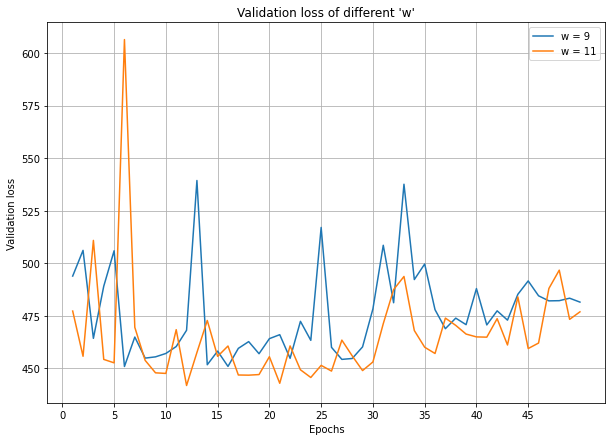

In [22]:
fig_loss = plt.figure(figsize = [10,7])
sns.lineplot(x = epochs,y=(np.array(val_loss9)))
sns.lineplot(x = epochs,y=(np.array(val_loss11)))
plt.title("Validation loss of different 'w'")
plt.legend(["w = 9","w = 11"])
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.grid()
plt.xticks(np.arange(0,50,5))
plt.show()

We can see that as the window size increases, we get lower and lower validation loss. For 7, it doesn't come down and is very high. Whereas for 9 and 11, we get a loss which comes down and then starts to overfit. Hence from selected 7,9,11 and 13, we chose w = 13 for model prediction.

In [23]:
#Test errors for all the sets. Lowest is for 13x13 window

model_7.evaluate(X_7_test,Y_test) #For 7x7 window
model_9.evaluate(X_9_test,Y_test) #For 9x9 window
model_11.evaluate(X_11_test,Y_test) #For 11x11 window
model.evaluate(X_test,Y_test) #For 13x13 window

417/417 [==============================] - 1s 1ms/step - loss: 434.9421


434.9421081542969

In [24]:
def predict_image_w(image,w):

  x,y = image.shape[0],image.shape[1] #Reading the shape of image
  image = np.reshape(image,(1,x,y,3))
  degraded_patch = tf.image.extract_patches(image,sizes=[1,w,w,1],strides=[1,1,1,1],rates = [1,1,1,1],padding = 'SAME') #Extracting patches of degraded image
  degraded_patch = tf.reshape(degraded_patch,[-1,w,w,3]) #Reshaping the patches to [N,w,w,3] where N is total patches of Image.

  X = tf.reshape(degraded_patch,[-1,w*w*3]).numpy() #converting patches into a 2D tensor, these work as input features.
  
  model_name = "model_" + str(w) + ".predict(X)"

  Y = eval(model_name)
  Y = (Y).astype(int)
  Y = np.where(Y > 255,255,Y) #Taking care of negative pixels
  Y = np.reshape(Y,(x,y,3))
  return Y
 

Text(0.5, 1.0, 'Original Image')

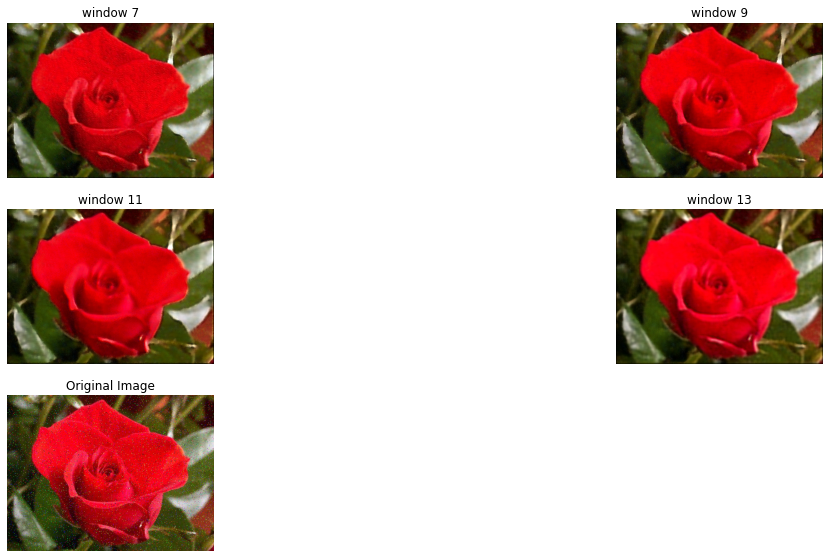

In [29]:
neutral_im = skimage.io.imread(r"/content/Rose.jpg")

figure_neural = plt.figure(figsize=[20,20])

figure_neural.add_subplot(6,2,1)
plt.imshow(predict_image_w(neutral_im,7))
plt.axis("off")
plt.title("window 7")

figure_neural.add_subplot(6,2,2)
plt.imshow(predict_image_w(neutral_im,9))
plt.axis("off")
plt.title("window 9")

figure_neural.add_subplot(6,2,3)
plt.imshow(predict_image_w(neutral_im,11))
plt.axis("off")
plt.title("window 11")

figure_neural.add_subplot(6,2,4)
plt.imshow(predict_image(neutral_im))
plt.axis("off")
plt.title("window 13")

figure_neural.add_subplot(6,2,5)
plt.imshow(neutral_im)
plt.axis("off")
plt.title("Original Image")

An observation we can see is that as window size increases, we keep on getting less zigzag pattern at certain edges. Hence 13 is the best size of window for this

# Model 2 : Using Random Forest Regression

Here we make use of Random forest regression to predict the central pixel.

Three Random forest regressor models are used. First is to predict red channel of cleaned pixel, second to predict blue channel of cleaned pixel and third to predict green channel of cleaned pixel.

In [34]:
from sklearn.ensemble import RandomForestRegressor

Three models that make use of 100 estimators and 33% of total samples to establish 1 estimator. Also the corresponding test and train samples from dataframe are converted into the numpy array.


Among 10,25 and 100, the best results were obtained for 100 estimators.

In [35]:
RF_R = RandomForestRegressor(n_estimators=100,max_samples = 0.33) #Defining model with 100 estimators for R channel
RF_G = RandomForestRegressor(n_estimators=100,max_samples = 0.33) #Defining model with 100 estimators for G channel
RF_B = RandomForestRegressor(n_estimators=100, max_samples = 0.33) #Defining model with 100 estimators for B channel

#Convert to numpy

X_RF = X_train.to_numpy() 
Y_RF = Y_train.to_numpy()

X_RF_valid = X_valid.to_numpy()
Y_RF_valid = Y_valid.to_numpy()

Fitting each individual model to the channel R (0), G(1) and B(2) of the central pixel in Y_train.

In [ ]:
RF_R.fit(X_RF,Y_RF[:,0]) 
RF_G.fit(X_RF,Y_RF[:,1])
RF_B.fit(X_RF,Y_RF[:,2])

Y_predict_R = RF_R.predict(X_RF_valid)
Y_predict_G = RF_G.predict(X_RF_valid)
Y_predict_B = RF_B.predict(X_RF_valid)

Here, we saved the models using joblib library so that we don't have to train the model again and again.

In [ ]:
import joblib

joblib.dump(RF_R, "/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestR.joblib")
joblib.dump(RF_G, "/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestG.joblib")
joblib.dump(RF_B, "/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestB.joblib")


['/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestB.joblib']

Importing the models from Joblib library

In [36]:
import joblib

RF_R = joblib.load("/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestR.joblib")
RF_G = joblib.load("/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestG.joblib")
RF_B = joblib.load("/content/drive/MyDrive/213070002_EE610_Assignment_2/RandomForestB.joblib")

Y_predict_R = RF_R.predict(X_RF_valid)
Y_predict_G = RF_G.predict(X_RF_valid)
Y_predict_B = RF_B.predict(X_RF_valid)

In [37]:
from sklearn import metrics

print("For R channel ... ")
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_RF_valid[:,0], Y_predict_R))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_RF_valid[:,0], Y_predict_R))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_RF_valid[:,0], Y_predict_R)))

print("\nFor G channel ...")
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_RF_valid[:,1], Y_predict_G))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_RF_valid[:,1], Y_predict_G))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_RF_valid[:,1], Y_predict_G)))

print("\nFor B channel ...")
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_RF_valid[:,2], Y_predict_B))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_RF_valid[:,2], Y_predict_B))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_RF_valid[:,2], Y_predict_B)))

For R channel ... 
Mean Absolute Error: 15.911626126126125
Mean Squared Error: 525.1762188288288
Root Mean Squared Error: 22.916723562255335

For G channel ...
Mean Absolute Error: 15.64193243243243
Mean Squared Error: 513.8399458858859
Root Mean Squared Error: 22.668037980510928

For B channel ...
Mean Absolute Error: 15.0769496996997
Mean Squared Error: 482.2345225900901
Root Mean Squared Error: 21.959838856195873


Lets predict few pixels from patches. Here again we randomly extract 5 patches from test data set and check whether our model predicts the output correctly or not.

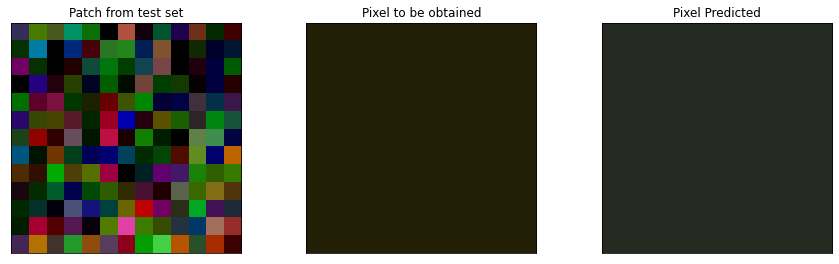

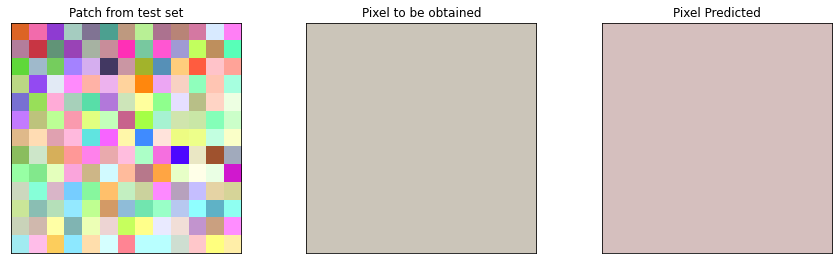

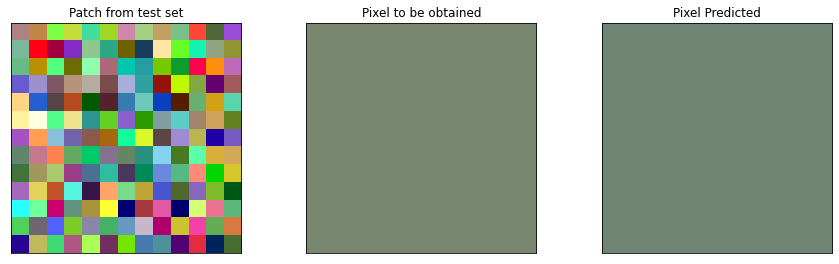

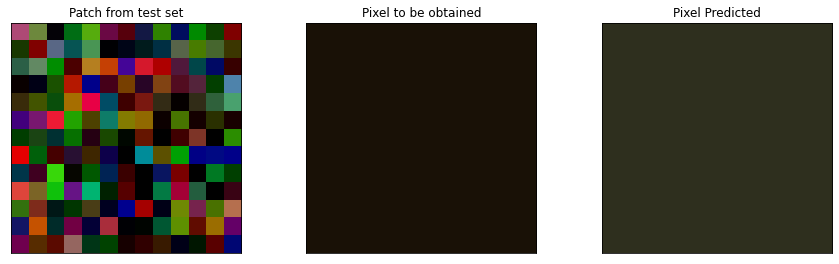

In [30]:
X_test_RF = X_test.to_numpy() #Convert test set to numpy 
Y_test_RF = Y_test.to_numpy()

#predict R,G,B values for central pixel and change the data type to int so that the value like 25.0, 67.0 etc. don't get treated like float.
#If these values are treated as float, then the image appears as white since 1.0 is max value pixel can take. Hence convert to int.

Y_predict_test_R = RF_R.predict(X_test_RF)
Y_predict_test_R = Y_predict_test_R.astype(int)

Y_predict_test_G = RF_G.predict(X_test_RF)
Y_predict_test_G = Y_predict_test_G.astype(int)

Y_predict_test_B = RF_B.predict(X_test_RF)
Y_predict_test_B = Y_predict_test_B.astype(int)

#A simple dataframe to store the test values for R,G,B of predicted pixel
Y_RF = pd.DataFrame({
    "Y_R" : Y_predict_test_R,
    "Y_G" : Y_predict_test_G,
    "Y_B" : Y_predict_test_B
}
)

N = 12128 #A random value, can be anything

#Showing the patch, corresponding central pixel of test set and predicted central pixel using Random Forest Regressors.

for i in range(N+1,N+5):

  X = X_test_RF[i,:]
  Y = Y_test_RF[i,:]
  Y2 = Y_RF.iloc[i,:].to_numpy()

  X = np.reshape(X,(13,13,3))
  Y = np.reshape(Y,(1,1,3))
  Y2 = np.reshape(Y2,(1,1,3))

  figure = plt.figure(figsize=[15,50])

  figure.add_subplot(10,3,3*(i-N)-2)
  plt.imshow(X)
  plt.xticks([])
  plt.yticks([])
  plt.title("Patch from test set")
  
  figure.add_subplot(10,3,3*(i-N)-1)
  plt.imshow(Y)
  plt.xticks([])
  plt.yticks([])
  plt.title("Pixel to be obtained")

  figure.add_subplot(10,3,3*(i-N))
  plt.imshow(Y2)
  plt.xticks([])
  plt.yticks([])
  plt.title("Pixel Predicted")

  

Now we use the same images we used for Neural networks to predict the cleaned images.

In [38]:
path_test_img = r"/content/drive/MyDrive/EE_610_test/Degraded/"

test_image_1 = skimage.io.imread(path_test_img + "124084.jpg")
test_image_2 = skimage.io.imread(path_test_img + "35010.jpg")
test_image_3 = skimage.io.imread("/content/grapes.jpg")
test_image_4 = skimage.io.imread("/content/Rose.jpg")


def predict_image_RF(image):
  
  x,y = image.shape[0],image.shape[1] #Reading the shape of image
  image = np.reshape(image,(1,x,y,3))
  degraded_patch = tf.image.extract_patches(image,sizes=[1,13,13,1],strides=[1,1,1,1],rates = [1,1,1,1],padding = 'SAME') #Extracting patches of degraded image
  degraded_patch = tf.reshape(degraded_patch,[-1,13,13,3])

  X = tf.reshape(degraded_patch,[-1,13*13*3]).numpy() #converting patches into a 2D tensor, these work as input features.
  Y_red = RF_R.predict(X).astype(int)
  Y_green = RF_G.predict(X).astype(int)
  Y_blue = RF_B.predict(X).astype(int)
  
  Y_RF = pd.DataFrame(
  {
    "Y_R" : Y_red,
    "Y_G" : Y_green,
    "Y_B" : Y_blue
  }
  ).to_numpy() 

  Y_RF = np.where(Y_RF > 255,255,Y_RF)
  Y_RF = np.reshape(Y_RF,(x,y,3))
  return Y_RF
  

Y1 = (predict_image_RF(test_image_1))
Y2 = (predict_image_RF(test_image_2))
Y3 = (predict_image_RF(test_image_3))
Y4 = (predict_image_RF(test_image_4))


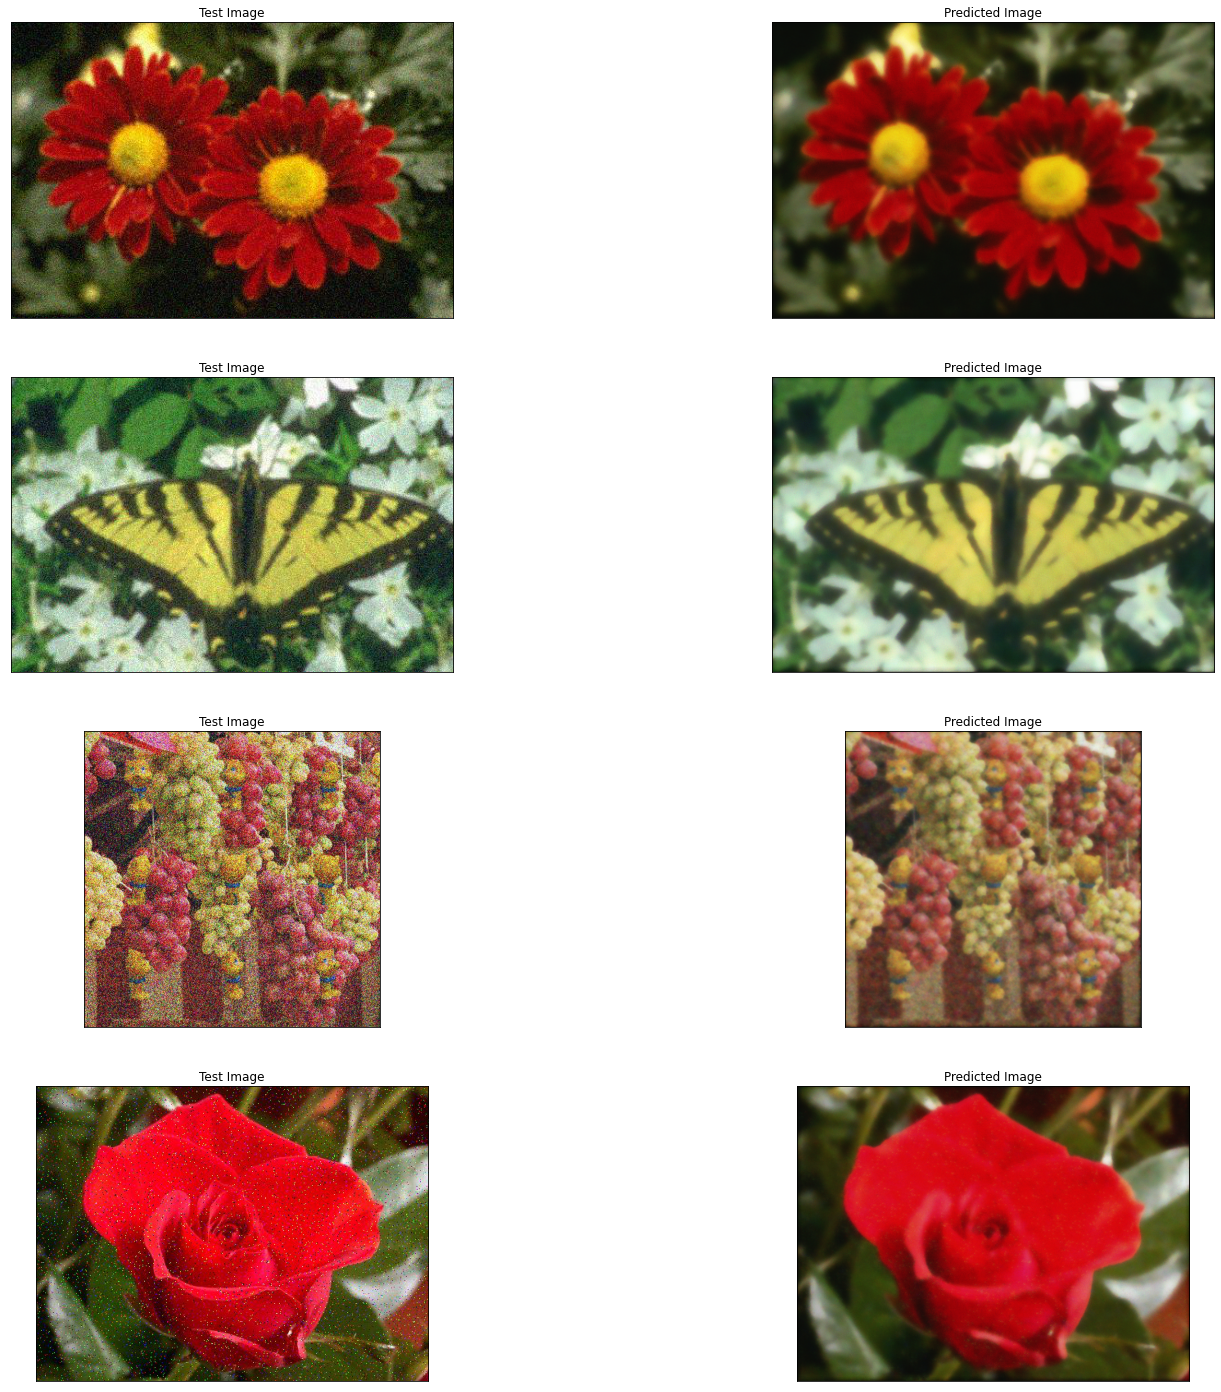

In [39]:
figure1 = plt.figure(figsize = [25,25])

for i in range(0,4):

  figure1.add_subplot(4,2,2*(i) + 1)
  test = "test_image_" + str(i+1)
  plt.imshow(eval(test))
  plt.title("Test Image")
  plt.xticks([])
  plt.yticks([])

  figure1.add_subplot(4,2,2*(i+1))
  Y = "Y"+str(i+1)
  plt.imshow(eval(Y))
  plt.title("Predicted Image")
  plt.xticks([])
  plt.yticks([])

plt.show()

# Summary

Finally, we apply our models on few natural images and see whether they can be denoised or not.

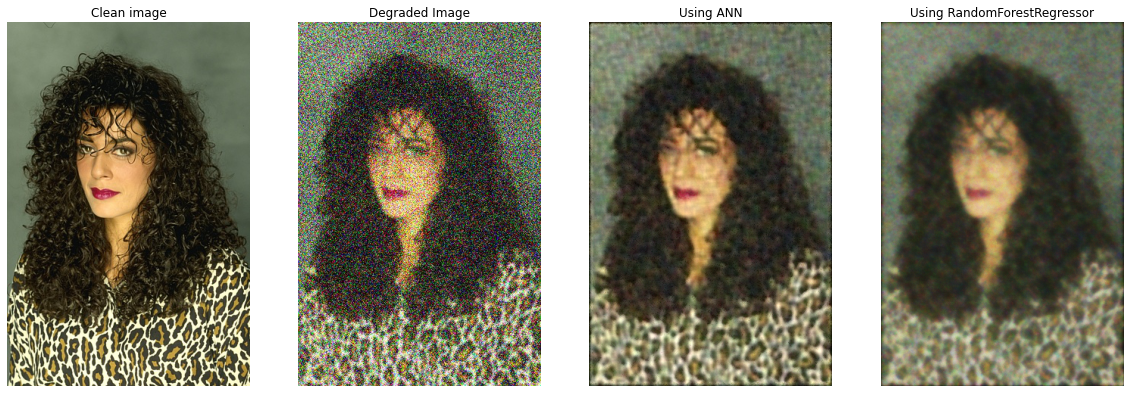

In [44]:
model_test_img_path = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/train/198054.jpg"

model_test_img_degraded = r"/content/drive/MyDrive/213070002_EE610_Assignment_2/Degraded/198054.jpg"

I_clean = skimage.io.imread(model_test_img_path) 
I = skimage.io.imread(model_test_img_degraded)

figure_final = plt.figure(figsize = [20,50])

figure_final.add_subplot(1,4,1)
plt.imshow(I_clean)
plt.axis("off")
plt.title("Clean image")

figure_final.add_subplot(1,4,2)
plt.imshow(I)
plt.axis("off")
plt.title("Degraded Image")

figure_final.add_subplot(1,4,3)
plt.imshow((predict_image(I)))
plt.axis("off")
plt.title("Using ANN")

figure_final.add_subplot(1,4,4)
plt.imshow((predict_image_RF(I)))
plt.axis("off")
plt.title("Using RandomForestRegressor")
plt.show()

Combining the two models, we get following

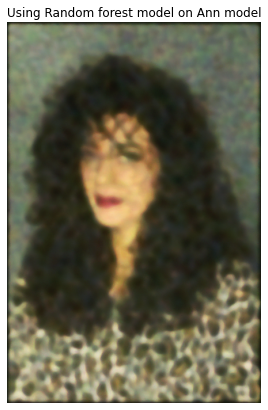

In [50]:
fig = plt.figure(figsize = [7,7])
fig.add_subplot(1,1,1)
plt.imshow(predict_image_RF(predict_image(I)))
plt.axis("off")
plt.title("Using Random forest model on Ann model")
plt.show()

Using a random noisy image from internet obtained from the following link : https://www.tripadvisor.com/LocationPhotoDirectLink-g261638-d1226646-i154158195-Northwind_Beachfront_Holiday_Apartments-Mooloolaba_Sunshine_Coast_Queens.html

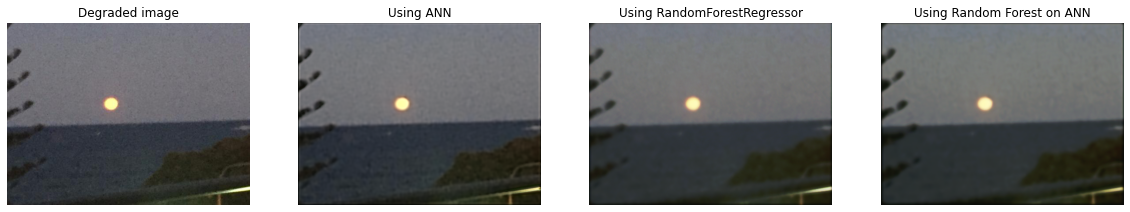

In [52]:
model_test_img_degraded = r"/content/sunset.jpg"

I = skimage.io.imread(model_test_img_degraded)

figure_final = plt.figure(figsize = [20,50])

figure_final.add_subplot(1,4,1)
plt.imshow(I)
plt.axis("off")
plt.title("Degraded image")

figure_final.add_subplot(1,4,4)
plt.imshow(predict_image_RF(predict_image(I)))
plt.axis("off")
plt.title("Using Random Forest on ANN")

figure_final.add_subplot(1,4,2)
plt.imshow((predict_image(I)))
plt.axis("off")
plt.title("Using ANN")

figure_final.add_subplot(1,4,3)
plt.imshow((predict_image_RF(I)))
plt.axis("off")
plt.title("Using RandomForestRegressor")
plt.show()

Thus, Noise is better removed by Random Forest Regressor whereas ANN is a little more sharper compared to Random Forest Regressor. 

Also when we combine both the models, results are good. Also did not use SVR because a simple SVR Model took very high time to train itself

References :

https://keras.io/

https://www.tensorflow.org/api_docs

https://medium.com/@shoray.goel/gelu-gaussian-error-linear-unit-4ec59fb2e47c

https://scikit-image.org/docs/0.18.x/

https://scikit-learn.org/stable/

https://levelup.gitconnected.com/de-blurring-images-using-convolutional-neural-networks-with-code-51d3f8d7b1d7

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Discussions: 

Shashwat Pathak : 213070010

Harsh Diwakar : 213070018

Binaya Kumar Sahoo : 213070009

Mohit Meena : 213070021